In [1]:
import tensorflow as tf
import pandas as pd
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import random
tf.reset_default_graph() 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPU

C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\pyth

In [2]:
folder = 'election_GAN/'
gen_results = 'generated_results/'

model = 'model_'+'.ckpt'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

# save ckpt
saver_path = os.path.join(folder, model)

# read ckpt
restore_path = os.path.join(folder)

# save generated data
generated_path = os.path.join(folder + gen_results)

In [3]:
# one hot code
def one_hot ( labels , Label_class ): 
    one_hot_label = np.array([[ int (i == int (labels[j])) for i in range (Label_class)] for j in range ( len (labels))])      
    return one_hot_label

In [4]:
img_width = 30
img_height = 24

data_alt3 = pd.read_csv('./data/netflix_data_3alt_resize.csv')
data_alt3 = data_alt3.iloc[:1000,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
print(data_alt3.shape)

##################################
data_alt4 = pd.read_csv('./data/netflix_data_4alt_resize.csv')
data_alt4 = data_alt4.iloc[:1000,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
print(data_alt4.shape)

data_alt_3_4 = np.concatenate( (data_alt3, data_alt4), axis = 0)
print(data_alt_3_4.shape)


(1000, 24, 30)
(1000, 24, 30)
(2000, 24, 30)


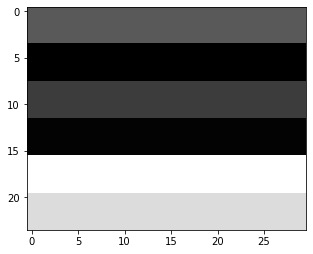

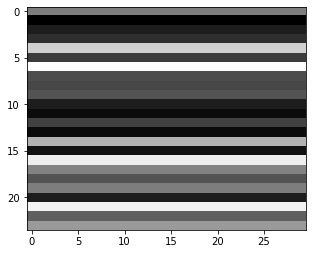

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(data_alt3[2], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(data_alt4[99], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

In [6]:
label_alt3 = np.zeros([data_alt3.shape[0]])
label_alt4 = np.zeros([data_alt4.shape[0]]) + 1
label_alt_3_4 = np.concatenate( (label_alt3,label_alt4), axis = 0)

label_alt_onehot = one_hot(label_alt_3_4, 1 + 1)   
print(label_alt_onehot.shape)

(2000, 2)


In [7]:
np.random.seed(0)
np.random.shuffle(data_alt_3_4)

np.random.seed(0)
np.random.shuffle(label_alt_onehot)

In [8]:
class election_GAN(object):
    def __init__(self,
                num_samples = None,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,
                _reuse = None):
        
        # Definition Params:
        self.num_samples = num_samples  
        self.dim_height = dim_height    
        self.dim_width = dim_width  
        self.dim_z = dim_z    
        self.num_class = num_class      
        self.batch_size = batch_size  

        # Define Network Input:
        self.X = tf.placeholder(tf.float32, shape=(self.batch_size, self.dim_height, self.dim_width, 1))
        self.Z = tf.placeholder(tf.float32, shape=(self.batch_size, 1, 1, self.dim_z))
        self.Y_label = tf.placeholder(tf.float32, shape=(self.batch_size, 1, 1, self.num_class))
        self.Y_fill = tf.placeholder(tf.float32, shape=(self.batch_size, self.dim_height, self.dim_width, self.num_class))
        self.isTrain = tf.placeholder(dtype=tf.bool)
        self.keep_prob_feed = tf.placeholder(tf.float32)
        self.global_step = tf.Variable(0, trainable = False)
        
        # Network:
        self._GEN(self.Z, self.Y_label, self.keep_prob_feed, self.isTrain, _reuse)
        
        self._DIS(self.X, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse)
        
        with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
            self._object_cost_function()        
        
    def _GEN(self, Z, Y_label, keep_prob_feed, isTrain=True, _reuse=False):

        with tf.variable_scope("GEN", reuse=_reuse):
            dim = 128

            # concat layer
            Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
            Z_ = tf.reshape(Z_, (-1, self.dim_z + self.num_class))        

            # FCN 
            hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)
            hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

            # CNN 1 
            hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)

            # CNN 2 
            hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)     

            # CNN 3 
            hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
            output = hidden

            return output     
    
    def _DIS(self, X, Y_fill, keep_prob_feed, isTrain=True, _reuse=False):

        with tf.variable_scope("DIS", reuse=_reuse):
            dim = 128
            leak = 0.2
            # concat layer
            X_ = tf.concat([X, Y_fill], 3)  #(batch_size, dim_height, dim_width, channel + num_class)

            # CNN 1 
            hidden = tf.layers.conv2d(X_, 1*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 2 
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 3
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # Flatten layer
            hidden = tf.layers.flatten(hidden)
            print(hidden.shape)
            score = tf.layers.dense(hidden, units = 1)
            score = tf.reshape(score, (-1, 1))          

            return score
    
    def _object_cost_function(self):
        # networks : generator
        self.fake_output = self._GEN(self.Z, self.Y_label, self.keep_prob_feed, self.isTrain, _reuse=False)

        # networks : discriminator
        real_score = self._DIS(self.X, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=False)
        fake_score = self._DIS(self.fake_output, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=True)

        '''define the loss ops'''
        self.D_loss = tf.reduce_mean(-real_score + fake_score)
        self.G_loss = tf.reduce_mean(-fake_score) 

        ################  Gradient penalty  ################
        LAMBDA = 10
        alpha = tf.random_uniform(shape=[self.batch_size, 1], minval=0.,maxval=1.)  

        real_data = tf.reshape(self.X, (self.batch_size, self.dim_height*self.dim_width))    
        fake_data = tf.reshape(self.fake_output, (self.batch_size, self.dim_height*self.dim_width))    

        interpolates = (alpha * real_data + ((1 - alpha) * fake_data))    
        interpolates_d = tf.reshape(interpolates, (self.batch_size, self.dim_height, self.dim_width, 1))  
        interpolates_d = self._DIS(interpolates_d, self.Y_fill, self.keep_prob_feed, self.isTrain, _reuse=True)                   

        gradients = tf.gradients(interpolates_d, [interpolates])[0]   
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))  
        gradient_penalty = tf.reduce_mean((slopes-1.)**2) 
        self.D_loss = self.D_loss + LAMBDA*gradient_penalty
        ###############  Gradient penalty  ################


        # define the optimizer ops
        self.T_vars = tf.trainable_variables()
#         self.D_vars = [var for var in self.T_vars if var.name.startswith('DIS')]
#         self.G_vars = [var for var in self.T_vars if var.name.startswith('GEN')]
        self.D_vars = [var for var in self.T_vars if 'DIS' in var.name]
        self.G_vars = [var for var in self.T_vars if 'DIS' not in var.name]
        
        learning_rate = 0.0001
        # define the update ops to run batch normalization
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
#             self.D_optim = tf.train.RMSPropOptimizer(learning_rate).minimize(self.D_loss, var_list=self.D_vars)
#             self.G_optim = tf.train.RMSPropOptimizer(learning_rate).minimize(self.G_loss, var_list=self.G_vars)
            self.D_optim = tf.train.AdamOptimizer(learning_rate, beta1=0.5, beta2=0.9).minimize(self.D_loss, var_list=self.D_vars)
            self.G_optim = tf.train.AdamOptimizer(learning_rate, beta1=0.5, beta2=0.9).minimize(self.G_loss, var_list=self.G_vars)
            
            
    def train_model(self,
                    x_train = None,     
                    y_train = None,     
                    keep_prob = None,
                    train_epoch = None, 
                    n_critic = 5,
                    step_valid = 50
                   ): 
        
        self.train_hist = {}
        self.train_hist['D_losses'] = []
        self.train_hist['G_losses'] = []

        saver = tf.train.Saver()
        
        session_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))
        with tf.Session(config = session_config) as sess:
            sess.run(tf.global_variables_initializer())
            print('Optimization start!')

            for epoch in range(train_epoch):
                G_losses = []
                D_losses = []

                for i in range(len(x_train) // self.batch_size): # num_samples / batch_size
                    '''#############        Discriminator       #######################'''
                    x_ = x_train[i*self.batch_size: (i+1)*self.batch_size] 
                    x_ = x_.reshape((self.batch_size, self.dim_height, self.dim_width, 1))   #(batch_size, dim_height, dim_width, 1)
                    y_label_ = y_train[i*self.batch_size:(i+1)*self.batch_size].reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class]) #(batch_szie, height, width, num_class)
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))

                    loss_d, _ = sess.run([self.D_loss, self.D_optim], 
                                          feed_dict={self.X: x_, 
                                                     self.Z: z_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: keep_prob,
                                                     self.isTrain: True})
                    D_losses.append(loss_d)

                    '''#############        Generator          #######################'''
                    if (i+1) % n_critic == 0:   # Train the generator every n_critic iterations
                        z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))
                        y_ = []
                        for _ in range(self.batch_size): y_.append(random.randrange(0, self.num_class, self.num_class-1))  
                        y_ = np.array(y_).reshape([self.batch_size, 1])
        #                 y_ = np.random.randint(0, 2, (batch_size, 1))
                        y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                        y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                        loss_g, _ = sess.run([self.G_loss, self.G_optim], 
                                              feed_dict={self.Z: z_, 
                                                         self.X: x_, 
                                                         self.Y_fill: y_fill_, 
                                                         self.Y_label: y_label_, 
                                                         self.keep_prob_feed: keep_prob,
                                                         self.isTrain: True})
                        G_losses.append(loss_g)

            ############        print result      #######################
                if (epoch+1) % 1 == 0:
                    print('[%d/%d] loss_d: %.3f, loss_g: %.3f'%((epoch + 1), train_epoch, np.mean(D_losses), np.mean(G_losses)))
                    self.train_hist['D_losses'].append(np.mean(D_losses))
                    self.train_hist['G_losses'].append(np.mean(G_losses))

            ############        valid      #######################
                if (epoch+1) % step_valid == 0:
                   ############        num_alternative = 3      #######################
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   

                    y_ = np.zeros([self.batch_size, 1]) + 0
                    y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                    output_g_alt3 = sess.run([self.fake_output], 
                                          feed_dict={self.Z: z_, 
                                                     self.X: x_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: 1,
                                                     self.isTrain: False})    
                    output_g_alt3_ = np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width])[0]

                    ############        num_alternative = 4      #######################
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   

                    y_ = np.zeros([self.batch_size, 1]) + 1
                    y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])
                    y_fill_ = y_label_ * np.ones([self.batch_size, self.dim_height, self.dim_width, self.num_class])
                    output_g_alt4 = sess.run([self.fake_output], 
                                          feed_dict={self.Z: z_, 
                                                     self.X: x_, 
                                                     self.Y_fill: y_fill_, 
                                                     self.Y_label: y_label_, 
                                                     self.keep_prob_feed: 1,
                                            A         self.isTrain: False})  


                    output_g_alt4_ = np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width])[0]

                    plt.figure(epoch)
                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt3_, (self.dim_height, self.dim_width)), cmap='gray')

                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt4_, (self.dim_height, self.dim_width)), cmap='gray')            
                    plt.show()

            ###########        save      #######################
            saver.save(sess, saver_path)   
            print('save success')
        
            sess.close()

        print("Optimization Finished!")
        
    '''loss curve'''
    def show_train_hist(self):
        x = range(len(self.train_hist['D_losses']))

        y1 = self.train_hist['D_losses']
        y2 = self.train_hist['G_losses']

        plt.plot(x, y1, label='D_loss')
        plt.plot(x, y2, label='G_loss')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.legend(loc=4)  
        plt.grid(True)
        plt.tight_layout() 
        plt.title("Training Losses")

        plt.show()


In [9]:
num_samples = data_alt_3_4.shape[0]
dim_height = data_alt_3_4.shape[1]
dim_width = data_alt_3_4.shape[2]
dim_z = 128
num_class = label_alt_onehot.shape[-1]
batch_size = 50

In [12]:
model = election_GAN(
                num_samples = num_samples,
                dim_height = dim_height,
                dim_width = dim_width,
                dim_z = dim_z,
                num_class = num_class,
                batch_size = batch_size)


(50, 3072)
(50, 3072)
(50, 3072)
(50, 3072)


In [11]:
# model.train_model(
#     x_train = data_alt_3_4,     
#     y_train = label_alt_onehot,     
#     keep_prob = 0.5, #0.5
#     train_epoch = 17000, #17000
#     n_critic = 5,#5
#     step_valid = 50 #50
#     )

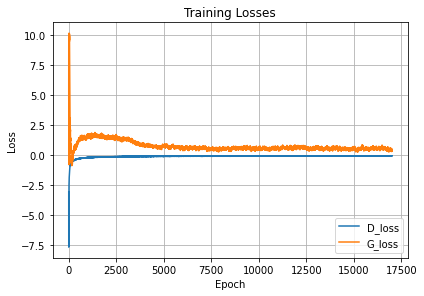

In [12]:
model.show_train_hist()

# Generating data

In [12]:
class election_GAN_GEN(object):
    def __init__(self,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,):
        
        # Definition Params:
        self.dim_height = dim_height    
        self.dim_width = dim_width  
        self.dim_z = dim_z    
        self.num_class = num_class      
        self.batch_size = batch_size  

        # Define Network Input:
        self.Z = tf.placeholder(tf.float32, shape=(None, 1, 1, self.dim_z))
        self.Y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, self.num_class))

        # Network:
        self._GEN(self.Z, self.Y_label)

        # get the generated data
        with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
            self.call_GEN()
        
    def _GEN(self, Z, Y_label):            
        keep_prob_feed = 1
        isTrain=False 
        dim = 128
        
        with tf.variable_scope("GEN", reuse=False):
            # concat layer
            Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
            Z_ = tf.reshape(Z_, (-1, self.dim_z + self.num_class))        

            # FCN 
            hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)
            hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

            # CNN 1 
            hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)

            # CNN 2 
            hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
            hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)     

            # CNN 3 
            hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
            output = hidden

            return output     
    
    def call_GEN(self):
        self.fake_output = self._GEN(self.Z, self.Y_label)

    def GEN_model(self, path, iteration): 
    
        saver = tf.train.Saver()

        gpu_options = tf.GPUOptions(allow_growth=True)
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
            saver.restore(sess, tf.train.latest_checkpoint(path))      
            
            generated_3alt = []
            generated_4alt = []  
            
            for _ in range(iteration): 
                '''#############        Generator          #######################'''
                ############        num_alternative = 3      #######################
                z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
                y_ = np.zeros([self.batch_size, 1]) + 0
                y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

                output_g_alt3 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})    
                output_g_alt3_ = np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width])
                generated_3alt.append(output_g_alt3_)
                
                ############        num_alternative = 4      #######################
                z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
                y_ = np.zeros([self.batch_size, 1]) + 1
                y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

                output_g_alt4 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})  
                output_g_alt4_ = np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width])
                generated_4alt.append(output_g_alt4_)

            generated_3alt = np.array(generated_3alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
            generated_4alt = np.array(generated_4alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
                
            return generated_3alt, generated_4alt

In [13]:
tf.reset_default_graph()

In [14]:
generator = election_GAN_GEN(
                dim_height = dim_height,
                dim_width = dim_width,
                dim_z = dim_z,
                num_class = num_class,
                batch_size = batch_size)


shape[0]: number of generated data

shape[1], shape[2]: data size before resize back to original size

In [15]:
iteration_generator = 50
gen_alt3, gen_alt4 = generator.GEN_model(path = restore_path, 
                                         iteration = iteration_generator) #iteration: how many times generator is used?
print(gen_alt3.shape) 
print(gen_alt4.shape)

INFO:tensorflow:Restoring parameters from election_GAN/model_.ckpt
(2500, 24, 30)
(2500, 24, 30)


<Figure size 432x288 with 0 Axes>

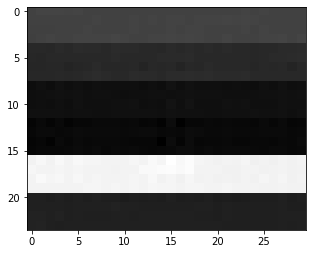

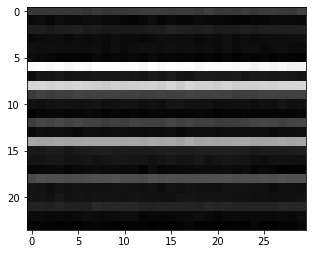

In [16]:
plt.figure(1)
fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(gen_alt3[0], (dim_height, dim_width)), cmap='gray')

fig, ax = plt.subplots(figsize=(5, 5))
ax.cla()
ax.imshow(np.reshape(gen_alt4[0], (dim_height, dim_width)), cmap='gray')            
plt.show()

# Resize to original shpe & Save as CSV

In [17]:
def resize_to_ori(x, img_size, img_width, img_height, ori_size):
    x = x.reshape([iteration_generator*batch_size, img_width*img_height])
    cell_size = int(img_size//ori_size)

    ori_dat = []
    for j in range(x.shape[0]):
        dat = x[j]
        tmp = []
        for i in range(dat.shape[0] // cell_size):
            k = dat[(i)*cell_size:(i+1)*cell_size]
            tmp.append(np.mean(k))
        ori_dat.append(tmp)
    ori_dat = np.array(ori_dat)    
    return ori_dat

In [18]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(3)

gen_alt3_ori = resize_to_ori(gen_alt3, img_size, img_width, img_height, ori_size)
gen_alt3_pd = pd.DataFrame(gen_alt3_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
print(gen_alt3_pd.shape)
gen_alt3_pd.head()

(2500, 6)


,ABC,ACB,BAC,BCA,CAB,CBA
0,0.162388,0.098283,0.035487,0.017650,0.608135,0.075052
1,0.280359,0.012606,0.317690,0.094890,0.171433,0.128127
2,0.093796,-0.000426,0.232938,0.154603,0.060517,0.465868
3,0.305113,0.026660,0.285722,0.098826,0.160946,0.136348
4,0.211145,0.008841,0.462814,0.137439,0.080222,0.098305


In [19]:
gen_alt3_pd.to_csv(generated_path + 'generated_atl3.csv')

In [20]:
img_size = np.math.factorial(6)
img_width = 30
img_height = 24
ori_size = np.math.factorial(4)

gen_alt4_ori = resize_to_ori(gen_alt4, img_size, img_width, img_height, ori_size)
gen_alt4_pd = pd.DataFrame(gen_alt4_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
       'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
       'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
print(gen_alt4_pd.shape)
gen_alt4_pd.head()

(2500, 24)


,ABCD,ACBD,BACD,BCAD,CABD,CBAD,DABC,DACB,DBAC,DBCA,...,BDAC,BDCA,CDAB,CDBA,ABDC,ACDB,BADC,BCDA,CADB,CBDA
0,0.048630,0.003010,0.022184,0.006000,0.007110,0.000250,0.225727,0.016231,0.188709,0.054323,...,0.148460,0.020839,0.013489,0.003164,0.067935,0.010479,0.011778,0.028495,0.004296,-0.001883
1,0.097221,0.020433,0.035657,0.040087,0.038815,0.008854,0.091036,0.033525,0.023566,0.035484,...,0.095959,0.013500,0.038300,0.017135,0.089064,0.054530,0.035347,0.124983,0.003153,0.036316
2,0.288749,0.078078,0.159161,0.129868,0.081483,0.032969,0.004275,0.000347,0.002596,0.009474,...,0.016312,0.008695,0.020783,0.017415,0.017715,0.010830,0.009976,0.104422,0.009860,0.022263
3,0.078718,0.069931,0.008853,0.142895,0.240552,0.097294,0.005020,0.010777,0.002621,0.015523,...,0.003419,0.003712,0.069043,0.032848,0.006456,0.015628,0.000456,0.071811,0.032202,0.079467
4,0.230894,0.095694,0.184935,0.243666,0.137969,0.046225,0.008653,0.000184,0.001092,0.002084,...,0.009032,0.001770,0.002798,-0.001014,0.013194,0.006829,0.005856,0.002694,0.000781,0.003291


In [21]:
gen_alt4_pd.to_csv(generated_path + 'generated_atl4.csv')